### S1_preprocessing

scRNA-Seq of Placental explants

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline
import seaborn as sns
import seaborn as sb
from glob import iglob
import anndata
import matplotlib as mpl
import skmisc

    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= '../results/images/preprocessing/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


### Import data

In [2]:
data_dir = '/lustre/scratch117/cellgen/team292/er13/placental_explant/starsolo/data/'

meta = pd.read_csv(data_dir+'/meta_plac_exp_all.csv',index_col=0)
meta['donor'] = meta['donor'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  12


In [3]:
meta

,donor,termination,day,pcw
sample,,,,
Pla_HDBR10917729,Hrv97,medical,d5,5pcw
Pla_HDBR10917730,Hrv98,surgical,d0,9pcw
Pla_HDBR10917731,Hrv99,medical,d0,8pcw
Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw
Pla_HDBR10917733,Hrv100,surgical,d0,5pcw
Pla_HDBR10917734,Hrv100,surgical,d2,5pcw
Pla_HDBR11345027,Hrv106,surgical,d0,17pcw
Pla_HDBR11345028,Hrv107,surgical,d0,11pcw
Pla_HDBR11345029,Hrv107,surgical,d2,11pcw


In [4]:
data_dir = '/lustre/scratch117/cellgen/team292/er13/placental_explant/starsolo/data/'

### Preprocessing

Basic filtering. 
Filter:
1) cells (< 100 genes);
2) genes (< 3 cells)

Quantify: 1) % mitochondrial genes; 2) total counts

In [5]:
holder = []
for sample in meta.index:
    print(sample)
    # Load 10x data as AnnData

    holder.append(sc.read_10x_mtx(data_dir+sample+'/output/GeneFull/filtered/',var_names='gene_symbols',cache=True)) 
    #holder.append(sc.read_10x_mtx(data_dir+sample+'/soupX_filt/')) 
    #holder.append(sc.read_10x_h5(data_dir+sample+'/cellbender.out/cellbender_out_filtered.h5'))
    # Set names of observation as sample + _ + barcode/probe
    print('Original number of cells: {:d}'.format(holder[-1].n_obs))
    
    holder[-1].var_names_make_unique()
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    # Filer cells with less than 100 genes expressed
    sc.pp.filter_cells(holder[-1], min_genes=100)
    # Filer genes expressed in less than 3 cells
    sc.pp.filter_genes(holder[-1], min_cells=3)
    # add in metadata
    holder[-1].obs['sample'] = sample
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
         holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

Pla_HDBR10917729
Original number of cells: 10057
Total number of cells: 9883
Total number of genes: 28233
Pla_HDBR10917730
Original number of cells: 15037
Total number of cells: 15037
Total number of genes: 28477
Pla_HDBR10917731
Original number of cells: 13402
Total number of cells: 13401
Total number of genes: 28142
Pla_HDBR10917732
Original number of cells: 27334
Total number of cells: 27334
Total number of genes: 28811
Pla_HDBR10917733
Original number of cells: 20505
Total number of cells: 20505
Total number of genes: 28573
Pla_HDBR10917734
Original number of cells: 3856
Total number of cells: 3818
Total number of genes: 25715
Pla_HDBR11345027
Original number of cells: 13162
Total number of cells: 13159
Total number of genes: 28602
Pla_HDBR11345028
Original number of cells: 14911
Total number of cells: 14910
Total number of genes: 29192
Pla_HDBR11345029
Original number of cells: 19279
Total number of cells: 19279
Total number of genes: 28919
Pla_HDBR11345031
Original number of cell

In [9]:
#Original cells
10057+15037+13402+27334+20505+3856+13162+14911+19279+21737+20323+13517

193120

In [10]:
# Cells after filter 1
9883+15037+13401+27334+20505+3818+13159+14910+19279+21737+20321+13517

192901

In [11]:
# confirm N samples
print(len(holder))
# merge datasets by taking the intersection of cells found between nucleis and cells 
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

12


AnnData object with n_obs × n_vars = 192901 × 31625
    obs: 'n_genes', 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9'

In [12]:
adata.obs.head()

,n_genes,sample,donor,termination,day,pcw,percent_mito,n_counts,batch
Pla_HDBR10917729_AAACCCACATCGAACT,1938,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0
Pla_HDBR10917729_AAACCCAGTAAGACCG,449,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0
Pla_HDBR10917729_AAACCCAGTGGGATTG,779,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0
Pla_HDBR10917729_AAACCCATCAACACCA,109,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0
Pla_HDBR10917729_AAACGAAAGCCTAACT,1178,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047320,3022.0,0


In [13]:
adata.write('../../starsolo/data/S1_preprocessed_normalized_adata.h5ad')

... storing 'sample' as categorical
... storing 'donor' as categorical
... storing 'termination' as categorical
... storing 'day' as categorical
... storing 'pcw' as categorical
... storing 'gene_ids-0' as categorical
... storing 'feature_types-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'feature_types-1' as categorical
... storing 'gene_ids-10' as categorical
... storing 'feature_types-10' as categorical
... storing 'gene_ids-11' as categorical
... storing 'feature_types-11' as categorical
... storing 'gene_ids-2' as categorical
... storing 'feature_types-2' as categorical
... storing 'gene_ids-3' as categorical
... storing 'feature_types-3' as categorical
... storing 'gene_ids-4' as categorical
... storing 'feature_types-4' as categorical
... storing 'gene_ids-5' as categorical
... storing 'feature_types-5' as categorical
... storing 'gene_ids-6' as categorical
... storing 'feature_types-6' as categorical
... storing 'gene_ids-7' as categorical
... storing '

In [36]:
adata=sc.read('../../starsolo/data/S1_preprocessed_normalized_adata.h5ad')

# Souporcell
Adding another column with deconvolution from souporcell

In [14]:
samples = list(np.unique(adata.obs['sample']))

In [15]:
samples = ['Pla_HDBR10917732']

In [16]:
samples

['Pla_HDBR10917732']

In [17]:
# reading in souporcell outputs
# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path = data_dir+'souporcell/souporcell_'+sample+'/clusters.tsv' #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #aadind the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR10917732


In [18]:
adata.obs['sample_barcode'] = adata.obs.index

In [19]:
adata.obs.head

<bound method NDFrame.head of                                    n_genes            sample   donor  \
Pla_HDBR10917729_AAACCCACATCGAACT     1938  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACCCAGTAAGACCG      449  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACCCAGTGGGATTG      779  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACCCATCAACACCA      109  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACGAAAGCCTAACT     1178  Pla_HDBR10917729   Hrv97   
...                                    ...               ...     ...   
Pla_HDBR11345033_TTTGTTGGTCGGCACT      742  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGGTCTCCCTA      633  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGGTCTGATCA      545  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGGTTGTTGCA      678  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGTCATGCCCT     1499  Pla_HDBR11345033  Hrv124   

                                  termination day    pcw  percent_mito  \
Pla_HDBR10917729_AAACCCACATCGAA

In [20]:
#Function to add the souporcell id

def add_souporcell_id(adata_obj, cell_id):
    '''
    Function to add the souporcell status (e.g. 0,1, not pooled, etc.) to the cells
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
    
    '''
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #print('sample',sample, 'barcode', cell_id)
    
    if curr_sample in samples:
        #extracts the table contained in the indicated key of the dictionary
        curr_souporcell_table = souporcell_clusters[curr_sample]
        
        if (cell_id in list(curr_souporcell_table.index)): #checking that the cells are into the data
            curr_assign = souporcell_clusters[curr_sample].loc[cell_id,'assignment']
            #print('returning',curr_assign)
            return(curr_assign)

        else:
            # cell barcode is filtered by souporcell
            return('filtered_by_souporcell')
    else:
        return('not_pooled')

In [21]:
%%time

adata.obs['souporcell_id'] = adata.obs['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x))

CPU times: user 40.2 s, sys: 4.89 ms, total: 40.2 s
Wall time: 40.2 s


In [22]:
adata.obs.head

<bound method NDFrame.head of                                    n_genes            sample   donor  \
Pla_HDBR10917729_AAACCCACATCGAACT     1938  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACCCAGTAAGACCG      449  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACCCAGTGGGATTG      779  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACCCATCAACACCA      109  Pla_HDBR10917729   Hrv97   
Pla_HDBR10917729_AAACGAAAGCCTAACT     1178  Pla_HDBR10917729   Hrv97   
...                                    ...               ...     ...   
Pla_HDBR11345033_TTTGTTGGTCGGCACT      742  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGGTCTCCCTA      633  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGGTCTGATCA      545  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGGTTGTTGCA      678  Pla_HDBR11345033  Hrv124   
Pla_HDBR11345033_TTTGTTGTCATGCCCT     1499  Pla_HDBR11345033  Hrv124   

                                  termination day    pcw  percent_mito  \
Pla_HDBR10917729_AAACCCACATCGAA

In [23]:
def decode_donors(adata_obj, cell_id):
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    curr_souporcell_cluster = adata_obj.obs.loc[cell_id, 'souporcell_id']
    
    # donor ID from 'donor_id' column
    #curr_donor_id = adata_obj.obs.loc[cell_id, 'donor']
    
    #Specific case for this sample. 0 corresponds to Pla_HDBR10917731 (Hrv99), and 1 to Pla_HDBR10917730 (Hrv98)
    if curr_sample == 'Pla_HDBR10917732':
        if curr_souporcell_cluster == '0':
            return('Hrv99')
        elif curr_souporcell_cluster == '1':
            return('Hrv98')
        elif '/' in curr_souporcell_cluster:
            return('souporcell_doublet')


In [24]:
%%time

adata.obs['donor_deconv'] = adata.obs['sample_barcode'].apply(lambda x: decode_donors(adata,x))

CPU times: user 2.86 s, sys: 0 ns, total: 2.86 s
Wall time: 2.86 s


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '1'),
  Text(1, 0, '0'),
  Text(2, 0, '1/0'),
  Text(3, 0, 'filtered_by_souporcell'),
  Text(4, 0, '0/1')])

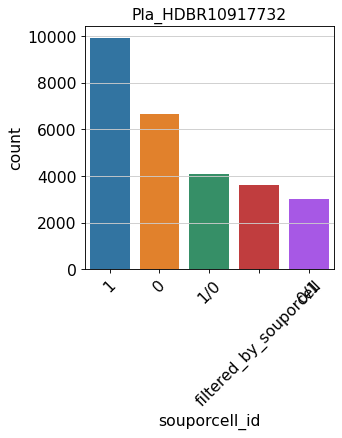

In [26]:
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['souporcell_id'],
                order=adata[adata.obs['sample'] == sample].obs['souporcell_id'].value_counts().index).set_title(sample)

plt.savefig(fig_path+'countplot_souporcell_id.pdf')
plt.xticks(rotation=45)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


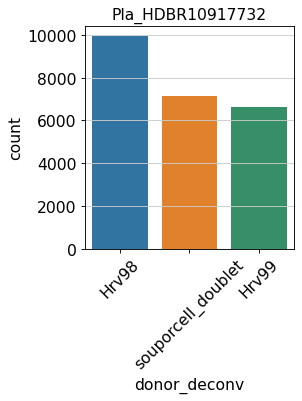

In [27]:
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['donor_deconv'],
                order=adata[adata.obs['sample'] == sample].obs['donor_deconv'].value_counts().index).set_title(sample)
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(fig_path+'countplot_donor_deconv.pdf')

In [28]:
# Number of cells after the souporcell doublet filtering
#len(adata.obs)

print('Total number of doublets: {:d}'.format(len(adata.obs.loc[adata.obs['donor_deconv'] == "souporcell_doublet"])))

Total number of doublets: 7145


Now that I have deconvoluted the donors, I will include the non-multiplexed cells into the donor_deconv column

In [29]:
adata.obs

,n_genes,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,sample_barcode,souporcell_id,donor_deconv
Pla_HDBR10917729_AAACCCACATCGAACT,1938,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,Pla_HDBR10917729_AAACCCACATCGAACT,not_pooled,None
Pla_HDBR10917729_AAACCCAGTAAGACCG,449,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,Pla_HDBR10917729_AAACCCAGTAAGACCG,not_pooled,None
Pla_HDBR10917729_AAACCCAGTGGGATTG,779,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,Pla_HDBR10917729_AAACCCAGTGGGATTG,not_pooled,None
Pla_HDBR10917729_AAACCCATCAACACCA,109,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0,Pla_HDBR10917729_AAACCCATCAACACCA,not_pooled,None
Pla_HDBR10917729_AAACGAAAGCCTAACT,1178,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047320,3022.0,0,Pla_HDBR10917729_AAACGAAAGCCTAACT,not_pooled,None
...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR11345033_TTTGTTGGTCGGCACT,742,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.029722,1043.0,11,Pla_HDBR11345033_TTTGTTGGTCGGCACT,not_pooled,None
Pla_HDBR11345033_TTTGTTGGTCTCCCTA,633,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.046256,908.0,11,Pla_HDBR11345033_TTTGTTGGTCTCCCTA,not_pooled,None
Pla_HDBR11345033_TTTGTTGGTCTGATCA,545,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.681453,3111.0,11,Pla_HDBR11345033_TTTGTTGGTCTGATCA,not_pooled,None
Pla_HDBR11345033_TTTGTTGGTTGTTGCA,678,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.022179,2074.0,11,Pla_HDBR11345033_TTTGTTGGTTGTTGCA,not_pooled,None


In [30]:
#Deleting the cells filtered by soc
adata= adata[adata.obs['souporcell_id'] != 'filtered_by_souporcell']


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


#### Correction of column values in metadata after deconvolution

In [31]:
def donor_assing(adata_obj, cell_id):
    
    '''
    Function that assings a donor ID to the cells that were pooled
    
    input
        adata_obj: adata object
        cell_id:

    '''
    
    #Donor deconvoluted of the current cell
    curr_donor_deconv = adata_obj.obs.loc[cell_id, 'donor_deconv']
    #Donor of the current cell (before deconvolution)
    curr_donor = adata_obj.obs.loc[cell_id, 'donor']
    
    # donor ID from 'donor_id' column
    
    #If the curr_donor_deconv is None, then the function willl return the donor before deconvolution
    # Otherwise it will return the same donor in the donor_deconv column. Which is the real donor. 
    if curr_donor_deconv == None:
        return(curr_donor)
    
    else:
        return(curr_donor_deconv)

    
    
def column_deconvCorrector(adata_obj, cell_id, column):
    
    '''
    Function that corrects values in a column of cell metadata with the correct names after deconvolution
    
    input
        adata_obj: adata object
        cell_id: cell id
        column: column to correct
    '''
    
    #sample, use as first filter
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    
    # donor ID from 'donor_id' column
    
    
    #Specific case for this sample.  Pla_HDBR10917732 is my multiplexed sample now
    # Pla_HDBR10917731 (Hrv99), and 1 to Pla_HDBR10917730 (Hrv98)
    
    # Current value in the column in this cell (before deconvolution)
    curr_columnValue = adata_obj.obs.loc[cell_id, column]
    
    if curr_sample == 'Pla_HDBR10917732':
        #Donor deconvoluted of the current cell
        curr_donor_deconv = adata_obj.obs.loc[cell_id, 'donor_souporcell']
        
        
        if curr_donor_deconv == 'Hrv99':
            #The day differs per run, so I will manually indicate the right day here
            if column == 'day':
                return('d2')
            
            else:
                #Here I obtain the list of values corresponding to the correct identity and get the
                # value corresponding to the column to correct
                correct_value = list(set(adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR10917731',column]))[0]
                return(correct_value)
        
        elif curr_donor_deconv == 'Hrv98':
            #The day differs per run, so I will manually indicate the right day here
            if column == 'day':
                return('d3')
            
            else:
                correct_value = list(set(adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR10917730',column]))[0]
                return(correct_value)
        
        # this is the sitation when the cell was identified as a doublet
        else:
            return(curr_columnValue) #keeping the original value in that column
        
    
    else:
        return(curr_columnValue)



In [32]:
#applying the donor_assing function to the data. The donor names will be stored in the new column donor_clean
adata.obs['donor_souporcell'] = adata.obs['sample_barcode'].apply(lambda x: donor_assing(adata,x))

Trying to set attribute `.obs` of view, copying.


In [33]:
adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR10917732']

,n_genes,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,sample_barcode,souporcell_id,donor_deconv,donor_souporcell
Pla_HDBR10917732_AAACCCAAGACCAGAC,8249,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.068460,69690.0,3,Pla_HDBR10917732_AAACCCAAGACCAGAC,0,Hrv99,Hrv99
Pla_HDBR10917732_AAACCCAAGACTCTTG,1724,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.095946,2960.0,3,Pla_HDBR10917732_AAACCCAAGACTCTTG,1,Hrv98,Hrv98
Pla_HDBR10917732_AAACCCAAGCATCCCG,4137,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.039373,11988.0,3,Pla_HDBR10917732_AAACCCAAGCATCCCG,1,Hrv98,Hrv98
Pla_HDBR10917732_AAACCCAAGCGAGTCA,2227,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.041861,7071.0,3,Pla_HDBR10917732_AAACCCAAGCGAGTCA,1,Hrv98,Hrv98
Pla_HDBR10917732_AAACCCAAGGAACGTC,1764,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.040012,3449.0,3,Pla_HDBR10917732_AAACCCAAGGAACGTC,1/0,souporcell_doublet,souporcell_doublet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR10917732_TTTGTTGTCAACTGGT,4019,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.007463,23584.0,3,Pla_HDBR10917732_TTTGTTGTCAACTGGT,1,Hrv98,Hrv98
Pla_HDBR10917732_TTTGTTGTCAGTCTTT,2658,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.052210,5497.0,3,Pla_HDBR10917732_TTTGTTGTCAGTCTTT,1,Hrv98,Hrv98
Pla_HDBR10917732_TTTGTTGTCCCGAACG,1194,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.028189,2093.0,3,Pla_HDBR10917732_TTTGTTGTCCCGAACG,0/1,souporcell_doublet,souporcell_doublet
Pla_HDBR10917732_TTTGTTGTCGAAGTGG,1648,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.067413,3575.0,3,Pla_HDBR10917732_TTTGTTGTCGAAGTGG,0,Hrv99,Hrv99


In [34]:
adata.obs.loc[adata.obs['sample'] != 'Pla_HDBR10917732']

,n_genes,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,sample_barcode,souporcell_id,donor_deconv,donor_souporcell
Pla_HDBR10917729_AAACCCACATCGAACT,1938,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,Pla_HDBR10917729_AAACCCACATCGAACT,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCAGTAAGACCG,449,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,Pla_HDBR10917729_AAACCCAGTAAGACCG,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCAGTGGGATTG,779,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,Pla_HDBR10917729_AAACCCAGTGGGATTG,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCATCAACACCA,109,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0,Pla_HDBR10917729_AAACCCATCAACACCA,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACGAAAGCCTAACT,1178,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047320,3022.0,0,Pla_HDBR10917729_AAACGAAAGCCTAACT,not_pooled,None,Hrv97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR11345033_TTTGTTGGTCGGCACT,742,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.029722,1043.0,11,Pla_HDBR11345033_TTTGTTGGTCGGCACT,not_pooled,None,Hrv124
Pla_HDBR11345033_TTTGTTGGTCTCCCTA,633,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.046256,908.0,11,Pla_HDBR11345033_TTTGTTGGTCTCCCTA,not_pooled,None,Hrv124
Pla_HDBR11345033_TTTGTTGGTCTGATCA,545,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.681453,3111.0,11,Pla_HDBR11345033_TTTGTTGGTCTGATCA,not_pooled,None,Hrv124
Pla_HDBR11345033_TTTGTTGGTTGTTGCA,678,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.022179,2074.0,11,Pla_HDBR11345033_TTTGTTGGTTGTTGCA,not_pooled,None,Hrv124


In [35]:
#applying the column_deconvCorrector function to the data. The column values for the
# deconvoluted samples will be corrected
adata.obs['pcw'] = adata.obs['sample_barcode'].apply(lambda x: column_deconvCorrector(adata,x,'pcw'))
adata.obs['termination'] = adata.obs['sample_barcode'].apply(lambda x: column_deconvCorrector(adata,x,'termination'))
adata.obs['day'] = adata.obs['sample_barcode'].apply(lambda x: column_deconvCorrector(adata,x,'day'))

In [36]:
adata.obs.loc[adata.obs['sample'] == 'Pla_HDBR10917732']

,n_genes,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,sample_barcode,souporcell_id,donor_deconv,donor_souporcell
Pla_HDBR10917732_AAACCCAAGACCAGAC,8249,Pla_HDBR10917732,Hrv98_Hrv99,surgical,d2,9pcw,0.068460,69690.0,3,Pla_HDBR10917732_AAACCCAAGACCAGAC,0,Hrv99,Hrv99
Pla_HDBR10917732_AAACCCAAGACTCTTG,1724,Pla_HDBR10917732,Hrv98_Hrv99,medical,d3,8pcw,0.095946,2960.0,3,Pla_HDBR10917732_AAACCCAAGACTCTTG,1,Hrv98,Hrv98
Pla_HDBR10917732_AAACCCAAGCATCCCG,4137,Pla_HDBR10917732,Hrv98_Hrv99,medical,d3,8pcw,0.039373,11988.0,3,Pla_HDBR10917732_AAACCCAAGCATCCCG,1,Hrv98,Hrv98
Pla_HDBR10917732_AAACCCAAGCGAGTCA,2227,Pla_HDBR10917732,Hrv98_Hrv99,medical,d3,8pcw,0.041861,7071.0,3,Pla_HDBR10917732_AAACCCAAGCGAGTCA,1,Hrv98,Hrv98
Pla_HDBR10917732_AAACCCAAGGAACGTC,1764,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.040012,3449.0,3,Pla_HDBR10917732_AAACCCAAGGAACGTC,1/0,souporcell_doublet,souporcell_doublet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR10917732_TTTGTTGTCAACTGGT,4019,Pla_HDBR10917732,Hrv98_Hrv99,medical,d3,8pcw,0.007463,23584.0,3,Pla_HDBR10917732_TTTGTTGTCAACTGGT,1,Hrv98,Hrv98
Pla_HDBR10917732_TTTGTTGTCAGTCTTT,2658,Pla_HDBR10917732,Hrv98_Hrv99,medical,d3,8pcw,0.052210,5497.0,3,Pla_HDBR10917732_TTTGTTGTCAGTCTTT,1,Hrv98,Hrv98
Pla_HDBR10917732_TTTGTTGTCCCGAACG,1194,Pla_HDBR10917732,Hrv98_Hrv99,med_surg,d3_d2,9pcw_8pcw,0.028189,2093.0,3,Pla_HDBR10917732_TTTGTTGTCCCGAACG,0/1,souporcell_doublet,souporcell_doublet
Pla_HDBR10917732_TTTGTTGTCGAAGTGG,1648,Pla_HDBR10917732,Hrv98_Hrv99,surgical,d2,9pcw,0.067413,3575.0,3,Pla_HDBR10917732_TTTGTTGTCGAAGTGG,0,Hrv99,Hrv99


In [37]:
remov

,n_genes,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,sample_barcode,souporcell_id,donor_deconv,donor_souporcell
Pla_HDBR10917729_AAACCCACATCGAACT,1938,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,6715.0,0,Pla_HDBR10917729_AAACCCACATCGAACT,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCAGTAAGACCG,449,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,858.0,0,Pla_HDBR10917729_AAACCCAGTAAGACCG,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCAGTGGGATTG,779,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,1581.0,0,Pla_HDBR10917729_AAACCCAGTGGGATTG,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACCCATCAACACCA,109,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.909489,1370.0,0,Pla_HDBR10917729_AAACCCATCAACACCA,not_pooled,None,Hrv97
Pla_HDBR10917729_AAACGAAAGCCTAACT,1178,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047320,3022.0,0,Pla_HDBR10917729_AAACGAAAGCCTAACT,not_pooled,None,Hrv97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR11345033_TTTGTTGGTCGGCACT,742,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.029722,1043.0,11,Pla_HDBR11345033_TTTGTTGGTCGGCACT,not_pooled,None,Hrv124
Pla_HDBR11345033_TTTGTTGGTCTCCCTA,633,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.046256,908.0,11,Pla_HDBR11345033_TTTGTTGGTCTCCCTA,not_pooled,None,Hrv124
Pla_HDBR11345033_TTTGTTGGTCTGATCA,545,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.681453,3111.0,11,Pla_HDBR11345033_TTTGTTGGTCTGATCA,not_pooled,None,Hrv124
Pla_HDBR11345033_TTTGTTGGTTGTTGCA,678,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.022179,2074.0,11,Pla_HDBR11345033_TTTGTTGGTTGTTGCA,not_pooled,None,Hrv124


In [38]:
set(list(adata.obs.donor))

{'Hrv100',
 'Hrv106',
 'Hrv107',
 'Hrv111',
 'Hrv124',
 'Hrv97',
 'Hrv98',
 'Hrv98_Hrv99',
 'Hrv99'}

In [39]:
#Check the donor categories
set(list(adata.obs.donor_souporcell))

{'Hrv100',
 'Hrv106',
 'Hrv107',
 'Hrv111',
 'Hrv124',
 'Hrv97',
 'Hrv98',
 'Hrv99',
 'souporcell_doublet'}

In [40]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 189288


# Scrublet

In [41]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    #reading the scrublet scores done in S0
    scrdf.append(pd.read_csv('../data/scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'soupX.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]
# In scrublet the significant p-value mark doublets
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

In [42]:
print('Total number of doublets: {:d}'.format(len(adata.obs.loc[adata.obs['is_doublet'] == True])))

Total number of doublets: 6352


In [43]:
#adata = adata[adata.obs['is_doublet'] == False, :]

In [44]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 189288


# QC plots

... storing 'termination' as categorical
... storing 'day' as categorical
... storing 'pcw' as categorical
... storing 'souporcell_id' as categorical
... storing 'donor_deconv' as categorical
... storing 'donor_souporcell' as categorical


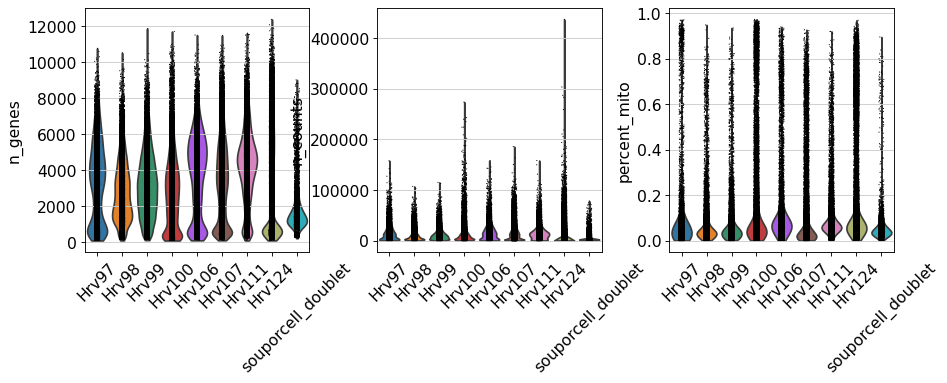

In [45]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_souporcell', rotation=45, save='_before_qc.pdf') 

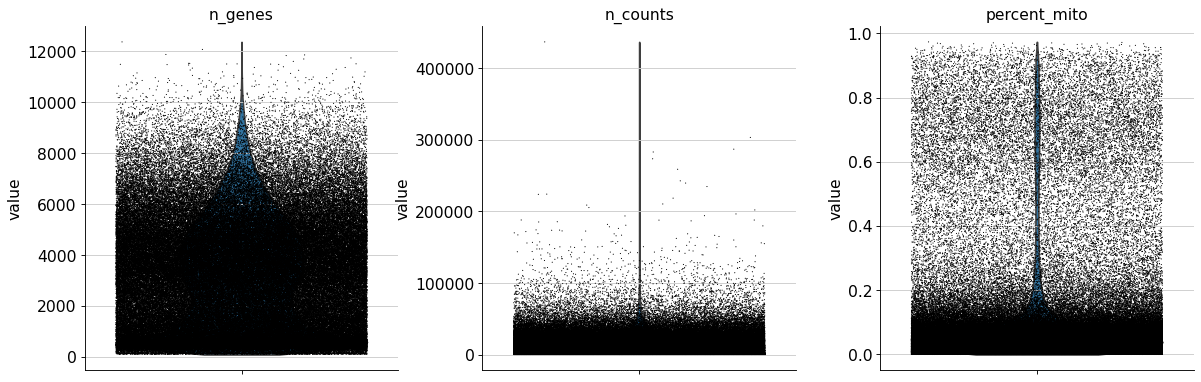

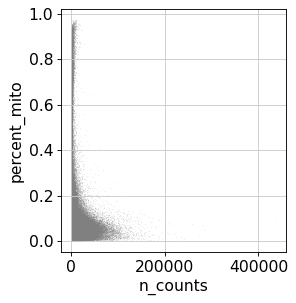

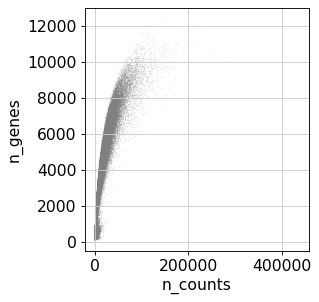

In [46]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf')
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf')
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf')

### Filtering the number of genes

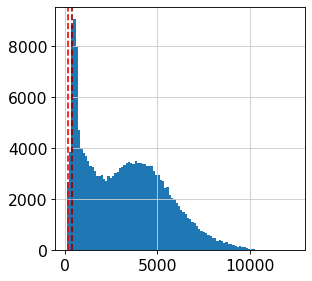

In [47]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(200, linestyle = '--', color = 'red')
plt.axvline(400, linestyle = '--', color = 'darkred')

In [48]:
#deleting the cells expressing less than 300 genes
sc.pp.filter_cells(adata, min_genes=300)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


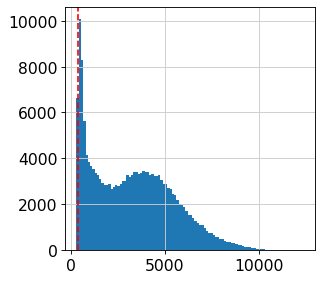

In [50]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(400, linestyle = '--', color = 'red')

In [51]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_souporcell'].values.describe()

Total number of cells: 184680
Total number of genes: 31625


,counts,freqs
categories,,
Hrv97,9459,0.051218
Hrv98,24555,0.132960
Hrv99,19819,0.107315
Hrv100,21956,0.118887
Hrv106,12720,0.068876
Hrv107,33818,0.183117
Hrv111,21622,0.117078
Hrv124,33609,0.181985
souporcell_doublet,7122,0.038564



### Filter cells by counts

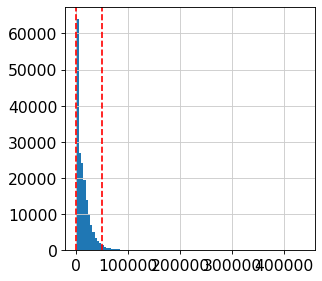

In [52]:
plt.hist(adata.obs['n_counts'], bins = 100)
plt.axvline(300, linestyle = '--', color = 'red')
plt.axvline(50000, linestyle = '--', color = 'red')

In [53]:
sc.pp.filter_cells(adata, min_counts = 300)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

#sc.pp.filter_cells(adata, max_counts = 50000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Number of cells after min count filter: 184680


In [54]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 184680
Total number of genes: 31625



### Filter cells with large % mitochondrial genes

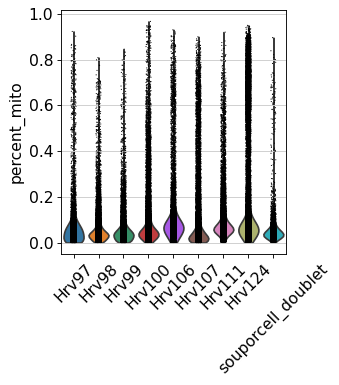

In [55]:
sc.pl.violin(adata, ['percent_mito'], groupby='donor_souporcell', rotation=45 ) #hPGCs

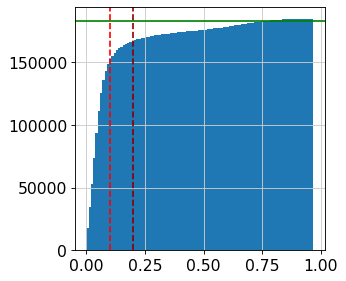

In [56]:
#Histogram Y number of cells, X mitocondrial percentage
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [57]:
# Keeping cells with <10%
adata = adata[adata.obs['percent_mito'] < 0.1, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [58]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 149617
Total number of genes: 31625


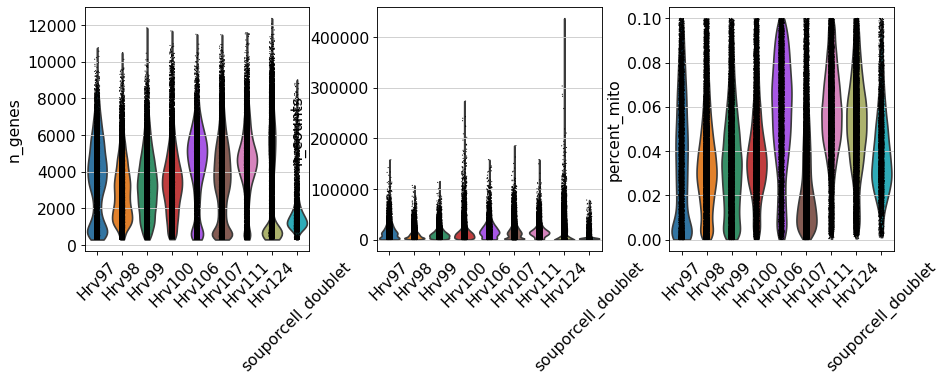

In [59]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_souporcell', rotation=45, save='_after_qc.pdf') 

In [60]:
adata.obs['sample'].values.describe()

,counts,freqs
categories,,
Pla_HDBR10917729,8118,0.054259
Pla_HDBR10917730,13156,0.087931
Pla_HDBR10917731,11973,0.080024
Pla_HDBR10917732,21392,0.142978
Pla_HDBR10917733,15411,0.103003
Pla_HDBR10917734,1461,0.009765
Pla_HDBR11345027,9059,0.060548
Pla_HDBR11345028,11590,0.077464
Pla_HDBR11345029,17580,0.117500


In [61]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_souporcell'].values.describe()

Total number of cells: 149617
Total number of genes: 31625


,counts,freqs
categories,,
Hrv97,8118,0.054259
Hrv98,22066,0.147483
Hrv99,17803,0.118990
Hrv100,16872,0.112768
Hrv106,9059,0.060548
Hrv107,29170,0.194964
Hrv111,17166,0.114733
Hrv124,22711,0.151794
souporcell_doublet,6652,0.044460



### Saving raw counts

In [62]:
adata_original = adata.copy()
adata_original.write('../data/S1_preprocessed_noNormalized_adata.h5ad')
#adata=sc.read('../data/S1_preprocessed_noNormalized_adata.h5ad')

In [63]:
adata= adata_original.copy()

In [4]:
adata

AnnData object with n_obs × n_vars = 149617 × 31625
    obs: 'n_genes', 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'souporcell_id', 'donor_deconv', 'donor_souporcell', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9'
    uns: 'donor_souporcell_colors'

## Highly variable genes


In [65]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


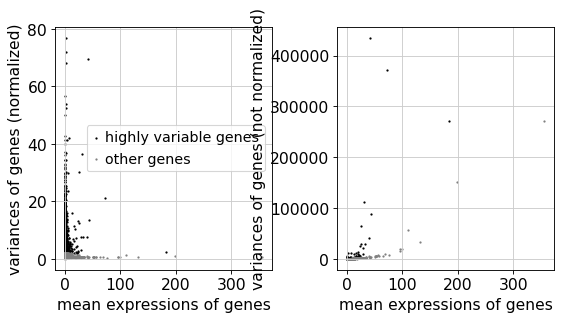

Total number of cells: 149617
Total number of genes: 3000


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
#  HVGs. Seurat 3 expects non-normalized counts
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata)

#saving the highl variable genes
highly_variable_genes = adata.var["highly_variable"]
adata = adata[:, highly_variable_genes]

print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

### Saving the annotation of HVGs

In [6]:
adata.var.to_csv('../results/tables/highlyVariable_genes.csv')

In [68]:
#adata_original = adata_original[:, highly_variable_genes]

In [64]:
#adata=sc.read('../data/S1_preprocessed_noNormalized_adata.h5ad')

In [65]:
#adata_original.write('../data/S1_preprocessed_noNormalized_highVarGenes_adata.h5ad')

## Calculate cell-cycle scores AND (optional)regress out cell cycle genes
We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

In [69]:
adata_original

AnnData object with n_obs × n_vars = 149617 × 31625
    obs: 'n_genes', 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'souporcell_id', 'donor_deconv', 'donor_souporcell', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9'
    uns: 'donor_souporcell_colors'

In [70]:
adata= adata_original.copy()

In [8]:
#Normalizing the data and scaling for the cell-cycle scoring
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


# Scale
sc.pp.scale(adata, max_value=10)
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 149617 × 3000
    obs: 'n_genes', 'sample', 'donor', 'termination', 'day', 'pcw', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'souporcell_id', 'donor_deconv', 'donor_souporcell', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'n_cells-8', 'gene_ids-9', 'feature_types-9', 'n_cells-9', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'donor_so

In [10]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open(data_dir+'regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['sample'].values.describe()

Total number of cells: 149617
Total number of genes: 3000


,counts,freqs
categories,,
Pla_HDBR10917729,8118,0.054259
Pla_HDBR10917730,13156,0.087931
Pla_HDBR10917731,11973,0.080024
Pla_HDBR10917732,21392,0.142978
Pla_HDBR10917733,15411,0.103003
Pla_HDBR10917734,1461,0.009765
Pla_HDBR11345027,9059,0.060548
Pla_HDBR11345028,11590,0.077464
Pla_HDBR11345029,17580,0.117500


In [12]:
#Saving only the DF with the cellcycle score and the classification. TO be use in the future
metadata= adata.obs
metadata[['S_score','G2M_score','phase']].to_csv('../results/tables/obs_metadata_cellCycle_score.csv')

In [13]:
#Saving only the DF with the cellcycle score and the classification. TO be use in the future
metadata= adata.obs
metadata[['donor_souporcell','G2M_score','phase']].to_csv('../results/tables/cellCycle_score.csv')

### PCA

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


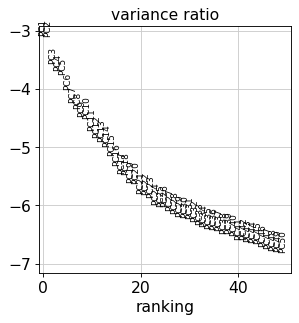

In [14]:
# Check PCA and extract PCA matrix
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, save=False)

In [15]:
adata.obs

,n_genes,sample,donor,termination,day,pcw,percent_mito,n_counts,batch,sample_barcode,...,donor_souporcell,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,S_score,G2M_score,phase
Pla_HDBR10917729_AAACCCACATCGAACT,1938,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.004617,486.0,0,Pla_HDBR10917729_AAACCCACATCGAACT,...,Hrv97,0.057737,0.056231,-0.321049,0.915588,1.0,False,-0.169172,-0.212259,G1
Pla_HDBR10917729_AAACCCAGTAAGACCG,449,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.008159,269.0,0,Pla_HDBR10917729_AAACCCAGTAAGACCG,...,Hrv97,0.012195,0.019023,-1.556773,0.950031,1.0,False,-0.086897,0.123129,G2M
Pla_HDBR10917729_AAACCCAGTGGGATTG,779,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.005693,166.0,0,Pla_HDBR10917729_AAACCCAGTGGGATTG,...,Hrv97,0.054764,0.056231,-0.321049,0.915588,1.0,False,0.415359,0.130257,S
Pla_HDBR10917729_AAACGAAAGCCTAACT,1177,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.047320,1064.0,0,Pla_HDBR10917729_AAACGAAAGCCTAACT,...,Hrv97,0.024876,0.023714,-1.400985,0.950031,1.0,False,0.793440,0.554083,S
Pla_HDBR10917729_AAACGAAAGCCTGGAA,3605,Pla_HDBR10917729,Hrv97,medical,d5,5pcw,0.066152,1172.0,0,Pla_HDBR10917729_AAACGAAAGCCTGGAA,...,Hrv97,0.107930,0.094984,0.965975,0.870682,1.0,False,-0.735054,-0.100691,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR11345033_TTTGTTGGTAAGATAC,628,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.030624,177.0,11,Pla_HDBR11345033_TTTGTTGGTAAGATAC,...,Hrv124,0.170877,0.114094,-0.207729,0.780360,1.0,False,-0.038184,-0.205868,G1
Pla_HDBR11345033_TTTGTTGGTCCCTGTT,690,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.054726,193.0,11,Pla_HDBR11345033_TTTGTTGGTCCCTGTT,...,Hrv124,0.124555,0.117446,0.000000,0.780360,1.0,False,0.369202,-0.204724,S
Pla_HDBR11345033_TTTGTTGGTCGGCACT,742,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.029722,210.0,11,Pla_HDBR11345033_TTTGTTGGTCGGCACT,...,Hrv124,0.110867,0.114094,-0.207729,0.780360,1.0,False,-0.174668,-0.089178,G1
Pla_HDBR11345033_TTTGTTGGTCTCCCTA,633,Pla_HDBR11345033,Hrv124,surgical,d2,11pcw,0.046256,184.0,11,Pla_HDBR11345033_TTTGTTGGTCTCCCTA,...,Hrv124,0.145119,0.120930,0.215942,0.780360,1.0,False,-0.155975,-0.039094,G1


### Save

In [16]:
adata.write('../data/S1_preprocessed_normalized_adata.h5ad')

... storing 'phase' as categorical


In [ ]:
n_pcs = 40
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['donor_souporcell','sample','phase', 'termination', 
                         'day','pcw','n_genes', 'phase'], ncols = 2, save='_preprocessing.pdf')